 ## Buzz wire challenge
 In the buzz wire game a metal loop is guided along a  wire. The goal is to 
 reach the end terminal of the wire without the loop touching the wire, in which 
 case a buzz noise is heard.
 
 Suppose that the game is played with a robot arm holding the metal loop. This 
 assignment aims at finding a strategy for the robot arm to move as fast as possible 
 from the start to the end terminal of the wire without touching the wire. For 
 simplicity, the following assumptions are considered:
 
 * The wire lies in a plane with $x$ and $y$ coordinates. Moreover, it can 
 be represented by a function $y=f(x)$ as depicted in the figure below, which 
 implies that it does not curve back.
 * The metal loop is represented by two small parallel bars, shown in blue 
 in the figure, which form a rigid body with center point represented by a blue 
 circle in the figure. Both the length of each bars and the space between the 
 two bars are set to $4.1$. The configuration of these parallel linear is characterized 
 by the position of the center point, denoted by $(p_x,p_y)$, and an orientation 
 angle $\theta \in (-\frac{\pi}{2},\frac{\pi}{2})$, which represents a rotation 
 angle with  respect to a frame with origin at the center point; $\theta = 0$ 
 when the two blue bars are parallel to the $x$ axis and $\theta >0$ corresponds 
 to an anti-clockwise rotation. The metal loop touches the wire if one of these 
 parallel bars intersects the wire. This check is performed for a finite set 
 of points of the bottom and top bars.
 * The space is discretized such that each coordinate position of the  center 
 point $(x,y)$ is a natural number, $x \in \{1,2,\dots,N_x\}$, $y \in \{1,2,\dots,N_y\}$ 
 and the angle belongs to the set $\theta \in \{-\frac{\pi}{2}+i\frac{\pi }{N_\theta+1}\}$, 
 for $i \in \{1,2,\dots,N_\theta\}$.
 * The game starts at time $k=1$ with $p_{x,1}=1$ and a feasible configuration 
 where the metal looop does not touch the wire.
 * The game is over when $p_{x,k}=N_x$ for a given $k=K+1$ and there have been 
 no colisions for every $k\leq K+1$. $K$ is the number of steps/times since the 
 inital step/time $k=1$, which should be minimized. 
 
 
 
 An example of an environment and a test to check if the metal loop touches 
 the wire is given next (you can click on run Section to avoid running the remainder 
 of the Live Script).

In [1]:
from IPython.display import clear_output
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [2]:
## 
# The following four functions are auxiliary functions for the algorithms.

def state2coord(i,Ny,Ntheta):
    ix     = np.floor(i/(Ny*Ntheta))+1
    iy     = np.floor((i-(ix-1)*(Ny*Ntheta))/Ntheta)+1
    itheta = i+1-(ix-1)*(Ny*Ntheta)-(iy-1)*Ntheta
    return int(ix), int(iy), int(itheta)


def coord2state(ix,iy,itheta,Ny,Ntheta):
    i = (ix-1)*Ny*Ntheta + (iy-1)*Ntheta + itheta
    return i


def action2coord(j,My,Mtheta):
    jx     = np.floor( j/(My*Mtheta))+1
    jy     = np.floor((j-(jx-1)*(My*Mtheta))/Mtheta)+1
    jtheta = j+1-(jx-1)*(My*Mtheta)-(jy-1)*Mtheta
    return jx, jy, jtheta


def coord2action(jx,jy,jtheta,My,Mtheta):
    j = (jx-1)*My*Mtheta + (jy-1)*Mtheta + jtheta
    return j

In [3]:
## 
# The following function determines the next state given the indices characterizing 
# the current state and the control action.

def nextstate(i,j,Nx,Ny,Ntheta,Mx,My,Mtheta):
    [ix,iy,itheta] = state2coord(i,Ny,Ntheta)
    [jx,jy,jtheta] = action2coord(j,My,Mtheta)
    ix_1     = min(ix+(jx-1),Nx)
    iy_1     = min(max(iy+jy-(My-1)/2-1,1),Ny)
    itheta_1 = min(max(itheta+jtheta-(Mtheta-1)/2-1,1),Ntheta)
    i_1 = coord2state(ix_1,iy_1,itheta_1,Ny,Ntheta)
    return i_1

In [4]:
## 
# The following function is an auxiliary function for solving the buzz wire 
# problem with stochastic dynamic programming.

def dpspstoch(M, C, p, Jh):
    n,m  = M.shape[0:2]
    np_     = p.shape[1]
    J      = np.copy(Jh)
    J_     = np.zeros((n,1))

    while(1):
        for i in range(n):
            if np.any(C[i,:] != np.inf):
                caux = np.zeros((1,m))
                for j in range(m):
                    caux[0,j] = 0
                    for l in range(np_):
                        caux[0,j] = caux[0,j] + p[0,l]*(C[i,j] + J[M[i,j,l]-1,0])
                J_[i,0] = np.min( caux )
            else:
                J_[i,0] = np.inf
        if np.all(J == J_):
            u_ = [[] for idx in range(n)]
            for i  in range(n):
                if np.any(C[i,:] != np.inf):
                    caux = np.zeros((1,m))
                    for j in range(m):
                        caux[0,j] = 0
                        for l in range(np_):
                            caux[0,j] = caux[0,j] + p[0,l]*(C[i,j] + J[M[i,j,l]-1,0])                 
                    #u_[i]       = find(J_(i) == caux )
                    u_[i] = np.flatnonzero(J_[i] == caux )
                else:
                    u_[i] = np.array([0])
            break
        else:
            J = np.copy(J_)
    return u_, J_    

In [5]:
## 
# The following function is an auxiliary function for solving the buzz wire 
# problem with deterministic dynamic programming.

def dpsp( M, C, Jh):
    n = M.shape[0]
    J = np.copy(Jh)

    J_ = np.zeros((n,1))
    while(1):
        for i in range(n):
            if np.any(C[i,:] != np.inf):
                J_[i]  = min( C[[i],:].T + J[M[i,:]-1] )
            else:
                J_[i] = np.inf
        if np.all(J == J_):
            u_ = [[] for idx in range(n)]
            for i in range(n):
                if np.any(C[i,:] != np.inf):
                    u_[i] = np.flatnonzero(J_[i] == C[i,:].T + J[M[i,:]-1,0] )
                else:
                    u_[i] = np.array([0])
            break
        else:
            J = np.copy(J_)
        
    return u_, J_

In [6]:
## 
# The following function solves the buzz wire deterministic problem with the 
# Dijkstra's algorithm.

def buzzwiredijkstra(Nx,Ny,Ntheta,Mx,My,Mtheta,wirefunction,x0):
    inode    = coord2state(*x0[0,:], Ny, Ntheta)
    nmax     = Nx*Ny*Ntheta          # max number of nodes
    m        = Mx*My*Mtheta
    openT    = np.column_stack((np.zeros(nmax), np.inf*np.ones(nmax), np.zeros(nmax))) # prealocate memory
    decT     = np.zeros((1,nmax))           # simply to keep track of optimal decisions, not necesary for the algorithm
    nopenT   = 1                     # number of nodes in openT

    openT[0,:] = np.array([[inode, 0, -1]])        #(node,cost-to-come to inode,prev. node)
    closedT    = np.column_stack((np.zeros(nmax), np.inf*np.ones(nmax), np.zeros(nmax))) # prealocate memory
    nclosed    = 0                         # number of nodes in closedT

    while(1):
        # shortest distance -(cur)node, add to closed, stop if terminal
        # curnodeind is index -> -1 compared to MATLAB
        curnodeind          = np.argmin(openT[:,1])
        curnode             = openT[curnodeind,0]
        curnodecost         = openT[curnodeind,1]
        nclosed             = nclosed + 1
        if nclosed > closedT.shape[0]:
            closedT = np.vstack((closedT, openT[curnodeind,:]))
        else:
            closedT[nclosed-1,:]  = openT[curnodeind,:]
        ix_ = state2coord(curnode-1,Ny,Ntheta)[0]
        if ix_ == Nx:
            fnode = curnode
            break
        
        # remove curnode from open, move last to its position
        if nopenT > 1:
            openT[curnodeind,:] = openT[nopenT-1,:]
        
        openT[nopenT-1,:] = (0, np.inf, 0)
        nopenT = nopenT-1
        
        # update neighboors of curnode
        # Obtain all valid neighboors that do not touch the wire
        for j in range(1,m+1):
            xneigh = nextstate(curnode-1,j-1,Nx,Ny,Ntheta,Mx,My,Mtheta)
            if not any(closedT[:,0] == xneigh): # if it in closed, skip it
                [ix_2,iy_2,itheta_2] = state2coord(xneigh-1,Ny,Ntheta)
                if metaltoucheswire(ix_2,iy_2,itheta_2,Nx,Ntheta,wirefunction):
                    # in neigh touches the wire put it in the closed list
                    nclosed = nclosed+1
                    if nclosed > closedT.shape[0]:
                        closedT = np.vstack((closedT, openT[int(xneigh)-1,:]))
                    else:
                        closedT[nclosed-1,:] = openT[int(xneigh)-1,:]
                else:
                    # if neigh does not touches the wire put it in open list if
                    # it is not there already, or otherwise update it
                    auxvec = openT[:,0] == xneigh
                    if any(auxvec): # if it is in the open list update
                        indneighopen = np.flatnonzero(auxvec)
                        if  curnodecost + 1 < openT[indneighopen,1]:
                            openT[indneighopen,1] = curnodecost + 1
                            openT[indneighopen,2] = curnode
                            decT[0,int(curnode)-1] = j
                        
                    else: # if not, add it to open
                        nopenT = nopenT + 1
                        openT[nopenT-1,0] = xneigh
                        openT[nopenT-1,1] = curnodecost + 1
                        openT[nopenT-1,2] = curnode
                        decT[0,int(curnode)-1] = j
                    
    optconfpathx, optconfpathy, optconfpaththeta = state2coord(fnode-1,Ny,Ntheta)
    optconfpath   = np.array([[optconfpathx, optconfpathy, optconfpaththeta]])
    optstateindex = fnode
    node = fnode
    while( node != inode ):
        indnode = np.flatnonzero( closedT[:,0] == node)
        node = closedT[indnode,2]
        optconfpathx, optconfpathy, optconfpaththeta = state2coord(node-1,Ny,Ntheta)
        optconfpath   = np.vstack((np.hstack([optconfpathx, optconfpathy, optconfpaththeta]), optconfpath))
        optstateindex = np.hstack((node, optstateindex))

    return optconfpath, optstateindex, decT

In [7]:
## 
# The following function solves the buzz wire problem with uncertainty with 
# stochastic dynamic programming.

def buzzwiredpstoch(Nx,Ny,Ntheta,Mx,My,Mtheta,wirefunction,CW,p,flag=0):

    np_ = p.shape[1]
    pcases = np.array([[-1, 1],\
        [0, 1],\
        [1, 1],\
        [-1, 0],\
        [0, 0],\
        [1, 0],\
        [-1, -1],\
        [0, -1],\
        [1, -1]])
    n = Nx*Ny*Ntheta
    m = Mx*My*Mtheta
    D  = np.zeros((n+1,m,np_),'int')
    C  = np.zeros((n+1,m))
    Jh      = np.inf*np.ones((n+1,1))
    Jh[n] = 0

    for i in range(n):
        [ix,iy,itheta] = state2coord(i,Ny,Ntheta)
        # terminal cost
        if ix == Nx:
            if not metaltoucheswire(ix,iy,itheta,Nx,Ntheta,wirefunction):
                Jh[i] = 0
                C[i,:] = 0
                D[i,:,:] = n+1
            else:
                Jh[i] = np.inf
                C[i,:] = np.inf
                D[i,:,:] = n+1
        else:
            if metaltoucheswire(ix,iy,itheta,Nx,Ntheta,wirefunction):
                C[i,:]   = CW
                D[i,:,:] = n+1
            else:
                for j in range(m):
                    C[i,j]    = 1
                    for ell in range(np_):
                        ix, iy, itheta = state2coord(i,Ny,Ntheta)
                        jx, jy, jtheta = action2coord(j,My,Mtheta)
                        ix_1       = min(max(ix+(jx-1)+pcases[ell,0],1),Nx)
                        iy_1       = min(max(iy+jy-(My-1)/2-1+pcases[ell,1],1),Ny)
                        itheta_1   = min(max(itheta+jtheta-(Mtheta-1)/2-1,1),Ntheta)
                        D[i,j,ell] = coord2state(ix_1,iy_1,itheta_1,Ny,Ntheta)
                    

    D[n,:] = n+1
    C[n,:] = 0

    mu_,J_ = dpspstoch( D, C, p, Jh)

    J  = np.zeros((Nx,Ny,Ntheta))
    mu = [[[[] for _ in range(Ntheta)] for _ in range(Ny)] for _ in range(Nx)]
    for i in range(n):
        ix,iy,itheta    = state2coord(i,Ny,Ntheta)
        J[ix-1,iy-1,itheta-1]   = J_[i] 
        if flag == 0:
            [jx,jy,jtheta]     = action2coord(mu_[i][0],My,Mtheta)
            mu[ix-1][iy-1][itheta-1] = [jx-1,jy-(My-1)/2-1,jtheta-(Mtheta-1)/2-1]
        else:
            for j in range(len(mu_[i])):
                jx,jy,jtheta       = action2coord(mu_[i][j],My,Mtheta)
                mu[ix-1][iy-1][itheta-1][j,0:2] = [jx-1,jy-(My-1)/2-1,jtheta-(Mtheta-1)/2-1]
            
    return mu, J         
        

In [8]:
## 
# The following function solved the buzz wire problem with dynamic programming.

def buzzwiredp(Nx,Ny,Ntheta,Mx,My,Mtheta,wirefunction,flag=0):

    n = Nx*Ny*Ntheta
    m = Mx*My*Mtheta

    D  = np.zeros((n,m), 'int')
    C  = np.zeros((n,m))
    Jh = np.inf*np.ones((n,1))
    for i in range(n): # i is index -> MATLAB_i - 1
        [ix,iy,itheta] = state2coord(i,Ny,Ntheta)
        # terminal cost
        if ix == Nx:
            if not metaltoucheswire(ix,iy,itheta,Nx,Ntheta,wirefunction):
                Jh[i] = 0
                C[i,:] = 0
                D[i,:] = i+1
            else:
                Jh[i] = np.inf
                C[i,:] = np.inf
                D[i,:] = i+1
            
        else:
            if metaltoucheswire(ix,iy,itheta,Nx,Ntheta,wirefunction):
                C[i,:] = np.inf
                D[i,:] = i+1
            else:
                for j in range(m): # j is index -> MATLAB_j - 1
                    C[i,j]    = 1
                    D[i,j]    = nextstate(i,j,Nx,Ny,Ntheta,Mx,My,Mtheta)
                
            
        

    [mu_,J_] = dpsp( D, C, Jh)

    J  = np.zeros((Nx,Ny,Ntheta))
    mu = [[[[] for _ in range(Ntheta)] for _ in range(Ny)] for _ in range(Nx)]
    for i in range(n):
        [ix,iy,itheta]    = state2coord(i,Ny,Ntheta)
        J[ix-1,iy-1,itheta-1]   = J_[i] 
        if flag == 0:
            [jx,jy,jtheta]     = action2coord(mu_[i][0],My,Mtheta)
            mu[ix-1][iy-1][itheta-1] = [jx-1,jy-(My-1)/2-1,jtheta-(Mtheta-1)/2-1]
        else: 
            for j in range(len(mu_[i])):
                [jx,jy,jtheta]       = action2coord(mu_[i][j],My,Mtheta)
                mu[ix-1][iy-1][itheta-1][j,0:2] = [jx-1,jy-(My-1)/2-1,jtheta-(Mtheta-1)/2-1]

    return mu,J       

In [9]:
## 
# The follwoing is a key function determining when the metal touches the wire.

def metaltoucheswire(ix,iy,itheta,Nx,Ntheta,wirefunction):
    spacingfingers = 4.1
    deltatheta  = np.pi/(Ntheta+1)
    theta       = itheta*deltatheta-np.pi/2
    deltawire   = (Nx-1)/(wirefunction.shape[0]-1)
    xwire       = ix
    ywire       = wirefunction[round((xwire-1)/deltawire)]
    if np.abs(ywire-iy)>spacingfingers:
        boolean = 1
    else:
        # four corners
        R  = np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]])
        d  = spacingfingers/2
        pu1 = np.array([[ix], [iy]]) + R@np.array([[-d, d]]).T
        pu2 = np.array([[ix], [iy]]) + R@np.array([[d, d]]).T
        pl1 = np.array([[ix], [iy]]) + R@np.array([[-d, -d]]).T
        pl2 = np.array([[ix], [iy]]) + R@np.array([[d, -d]]).T
        if pu2[0, 0] < 1 or pu1[0, 0] > Nx: # if the full metal arm is outside of the environemnt possibly the wire is such that it does not touch
            cu = 1
        else:
            indleftlimu  = round((max(min(pu1[0,0],Nx),1)-1)/deltawire)
            indrightlimu = round((max(min(pu2[0,0],Nx),1)-1)/deltawire)
            indtestu     = np.arange(indleftlimu,indrightlimu+1)
            xwireu = np.zeros((1,indtestu.shape[0]))
            ywireu = np.zeros((1,indtestu.shape[0]))
            ymetalu = np.zeros((1,indtestu.shape[0]))
            cu = np.zeros((1,indtestu.shape[0]))
            for i in range(indtestu.shape[0]):
                xwireu[0, i]   = 1+(indtestu[i])*deltawire
                ywireu[0, i]   = wirefunction[indtestu[i]]
                ymetalu[0, i]  = pu1[1, 0]+ (pu2[1, 0]-pu1[1, 0])/(pu2[0, 0]-pu1[0, 0])*(xwireu[0, i]-pu1[0, 0])
                cu[0, i]       = ymetalu[0, i]-ywireu[0, i] > 0
        
        if pl2[0, 0] < 1 or pl1[0, 0] > Nx:
            cl = 1
        else:
            indleftliml  = round((max(min(pl1[0,0],Nx),1)-1)/deltawire)
            indrightliml = round((max(min(pl2[0,0],Nx),1)-1)/deltawire)
            indtestl     = np.arange(indleftliml,indrightliml+1)
            xwirel = np.zeros((1,indtestl.shape[0]))
            ywirel = np.zeros((1,indtestl.shape[0]))
            ymetall = np.zeros((1,indtestl.shape[0]))
            cl= np.zeros((1,indtestl.shape[0]))
            for i in range(indtestl.shape[0]):
                xwirel[0, i]   = 1+(indtestl[i])*deltawire
                ywirel[0, i]   = wirefunction[indtestl[i]]
                ymetall[0, i]  = pl1[1, 0]+ (pl2[1, 0]-pl1[1, 0])/(pl2[0, 0]-pl1[0, 0])*(xwirel[0, i]-pl1[0, 0])
                cl[0, i]       = ymetall[0, i]-ywirel[0, i] < 0
        
        if np.all(cu == 1) & np.all(cl == 1):
            boolean = 0
        else:
            boolean = 1

    return boolean        

In [10]:
## 
# This function plots the environment and output a handler for the metal object 
# to be used by other functions.

def plotenvironment(Nx,Ny,Ntheta,wirefunction,ax):
    
    deltawire  = (Nx-1)/((wirefunction.shape[0])-1)
    spacingfingers = 4.1
    d  = spacingfingers/2
    plt.plot( [0, 0],[0, Ny+1],linewidth=2,color='black')
    plt.plot( [Nx+1, Nx+1],[0, Ny+1], linewidth=2, color='black')
    for ix in range(Nx):
        plt.plot( [ix,ix],[0, Ny+1], linewidth=1, color='black')

    for iy in range(Ny):
        plt.plot([0, Nx+1],[iy, iy], linewidth=1, color='black')

    plt.plot([0, Nx+1],[0, 0], linewidth=2, color='black')
    plt.plot([0, Nx+1],[Ny+1, Ny+1], linewidth=2, color='black')

    x_ = np.arange(1,Nx+deltawire,deltawire)
    plt.plot(x_,wirefunction, linewidth=2, color='red')
    
    tfinger1 = mpl.lines.Line2D([-d ,d],[d, d])
    tfinger2 = mpl.lines.Line2D([-d ,d],[-d, -d])
    tcircle  = mpl.patches.Circle([0,0],0.5)

    ax.add_line(tfinger1)
    ax.add_line(tfinger2)
    ax.add_patch(tcircle)
    
    ax.set_xlabel('x')
    ax.set_ylabel('y')

    tmetal = [tfinger1, tfinger2, tcircle]
    
    return  tmetal


## 
# This functions plots the metal.

def plotmetal(pmetal,tmetal,Ntheta,ax):

    itheta     = pmetal[2]
    deltatheta = np.pi/(Ntheta+1)
    theta      = itheta*deltatheta-np.pi/2
    rot =mpl.transforms.Affine2D().rotate(theta).translate(pmetal[0],pmetal[1]) + ax.transData
    tmetal[0].set_transform(rot)
    tmetal[1].set_transform(rot)
    tmetal[2].set_transform(rot)

def liveplot(Nx,Ny,Ntheta,wirefunction,pmetal):
    
    f, ax = plt.subplots(1)
    clear_output(wait=True)
    
    tmetal = plotenvironment(Nx,Ny,Ntheta,wirefunction,ax)
    plotmetal(pmetal,tmetal,Ntheta,ax)
    
    plt.show()

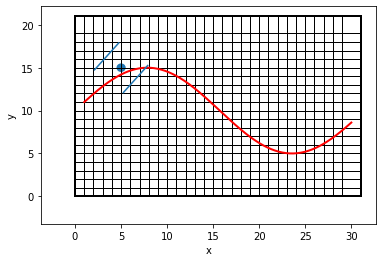

1


In [11]:

Nx     = 30
Ny     = 20
Ntheta = 17
Mx     = 4
My     = 5
Mtheta = 5
n = Nx*Ny*Ntheta
m = Mx*My*Mtheta
deltawire = 0.1
x_ = np.arange(1, Nx+deltawire, deltawire) 
wirefunction = 10*np.ones((x_.shape))+5*np.sin(0.2*x_)
print(metaltoucheswire(5,15,10,Nx,Ntheta,wirefunction))
liveplot(Nx,Ny,Ntheta,wirefunction,[5, 15, 14])
print(metaltoucheswire(5,15,14,Nx,Ntheta,wirefunction))

## Deterministic model
 A purely kinematic model for the robot holding the metal loop is considered 
 and it is assumed that the joint angles are such that the robot can reach all 
 the configurations of interest, therefore (using the robot kinematics) we can 
 assume that $x$, $y$, and $\theta$ can be controlled directly. The following 
 discrete-time model is considered
 
 $$  p_{x,k+1} =\min\{\max\{p_{x,k}+ u_{x,k},1\},N_x\} $$
 
 $$ p_{y,k+1} =\min\{\max\{p_{y,k}+ u_{y,k},1\},N_y \}$$           
 
 $$\theta_{k+1} =\min\{\max\{\theta_k+ \frac{ \pi}{N_\theta+1} u_{\theta,k},-\pi 
 \frac{ (N_\theta-1)/2}{N_\theta+1} \},\pi\frac{ (N_\theta-1)/2}{N_\theta+1} 
 \}$$
 
 with $u_{x,k}\in \{0,1,\dots,M_x-1\}$,   $u_{y,k}\in \{-(M_y-1)/2,-(M_y-1)/2+1,\dots,(M_y-1)/2\}$, 
 $u_{\theta,k}\in \{-(M_\theta-1)/2,-(M_\theta-1)/2+1,\dots,(M_\theta-1)/2\}$ 
 for odd $M_y$ and $M_\theta$.
 Stochastic model
 A more advanced stochastic model can specify that even if an action tries 
 to enforce that the metal loop arrives at a given configuration, this might 
 not be the case due to disturbances. Disturbances are assumed to only change 
 the position and not the angle. The exact discrete time model considered is 
 the following
 
 $$  p_{x,k+1} =\min \{\max\{p_{x,k}+ u_{x,k}+d_{x,k},1\},N_x\} $$
 
 $$ p_{y,k+1} =\min\{\max\{p_{y,k}+ u_{y,k}+d_{y,k},1\},N_y \}$$
 
 $$\theta_{k+1} =\min\{\max\{\theta_k+ \frac{ \pi}{N_\theta+1} u_{\theta,k},-\pi 
 \frac{ (N_\theta-1)/2}{N_\theta+1} \},\pi\frac{ (N_\theta-1)/2}{N_\theta+1} 
 \}$$
 
 where $d_{x,k} \in \{-1,0,1\}$ and $d_{y,k}\in \{-1,0,1\}$. The probabilities 
 of all the possible events are summarized in a vector $p = [p_1 \; p_2 \, p_3 
 \,\dots p_9]$ 
 
 $$ \text{Prob}[(d_{x,k},d_{y,k})=c_i]=p_i, i \in \{1,\dots,9\},$$
 
 with $c_1=(-1,1)$, $c_2=(0,1)$, $c_3=(1,1)$, $c_4=(-1,0)$, $c_5=(0,0)$, $c_6=(1,0)$, 
 $c_7=(-1,-1)$, $c_8=(0,-1)$, $c_9=(1,-1)$.
 
 Since the model is stochastic it might be the case that  collisions do occur, 
 even if uninteded (i.e., these would not occur if $(d_{x,k},d_{y,k})=(0,0)$ 
 ). If a collision occurs the game stops and a typically large positive penalty 
 $C_W$ is incurred. Note that if the metal wire is far from the end goal it might 
 be optimal to hit the wire (or risk to hit it) and incur a penaly CW instead 
 of incurring in a penalty coincinding with the time to reach the end.
 
 
 
 *Implementation*
 
 
 
 The following script allows to visualize the behavior of the dynamic programming 
 (stochflag = 0) and stochastic dynamic programming (stochflag = 1) policies 
 for the parameters given above (note that these will not work if the parameters 
 are changed). Note that the optimal policies and optimal paths are not unique 
 (only the costs-to-go and optimal number of steps are unique) and therefore 
 your implementation might and in general will lead to a different path. 

stochflag 0


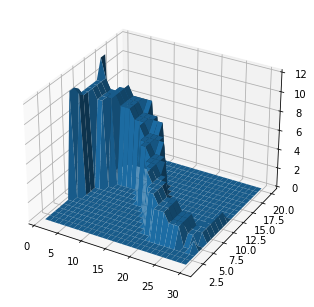

In [12]:
stochflag = 0  #0 DP, 1 -Stoch DP
print(f"stochflag {stochflag}")
if stochflag == 1:
    CW = 14
    p  = np.array([[0.04, 0.12, 0.04, 0.12, 0.36, 0.12, 0.04, 0.12, 0.04]])
    mu, J = buzzwiredpstoch(Nx, Ny, Ntheta, Mx, My, Mtheta, wirefunction, CW, p)
else:
    mu,J = buzzwiredp(Nx, Ny, Ntheta, Mx, My, Mtheta, wirefunction)

# optimal time (only for deterministic dp
x0 = np.array([[1, 10, 14]])
T  = J[x0[0,0]-1,x0[0,1]-1,x0[0,2]-1]

X,Y   = np.meshgrid(np.arange(1,Nx+1),np.arange(1,Ny+1), indexing='xy')
J_2     = np.inf*np.ones((Ny,Nx))
for ix in range(Nx):
    for iy in range(Ny):
        J_2[iy,ix] = np.min(J[ix,iy,:])
    

J_2[J_2 == np.inf] = 0

fig1 = plt.figure()
ax1 = Axes3D(fig1)
ax1.plot_surface(X,Y,J_2)

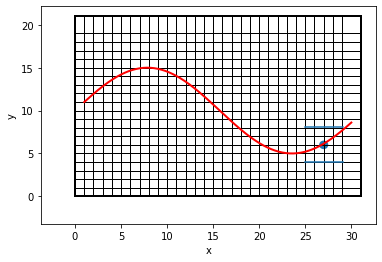

In [13]:
# animation
u = np.zeros((3,0))
x = x0.T
k = 0
while(True):
    liveplot(Nx,Ny,Ntheta,wirefunction,np.array([x[0,k], x[1,k], x[2,k]]))
    u = np.hstack((u, np.atleast_2d(mu[int(x[0,k])-1][int(x[1,k])-1][int(x[2,k])-1]).T))
    x = np.hstack((x, np.array([ \
            [min(x[0,k]+u[0,k],Nx)], \
            [min(max(x[1,k]+u[1,k],1),Ny)], \
            [min(max(x[2,k]+u[2,k],1),Ntheta)] \
        ])))
    if x[0,k+1] == Nx:
        break
    k = k+1

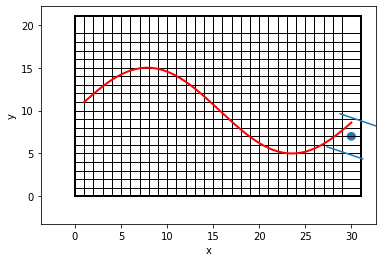

In [14]:
## 
# The following code allows you to check the behavior of the Dijkstra's algorithm.

x0            = np.array([[1, 10, 14]])
optpath = buzzwiredijkstra(Nx, Ny, Ntheta, Mx, My, Mtheta, wirefunction, x0)[0]

# figure
liveplot(Nx,Ny,Ntheta,wirefunction,np.array([x[0,k+1], x[1,k+1], x[2,k+1]]))

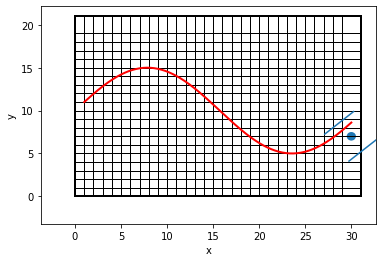

In [16]:
## 
# 

Toptpath      = optpath.shape[0]
for k in range(Toptpath):
    liveplot(Nx,Ny,Ntheta,wirefunction,np.array([optpath[k,0], optpath[k,1], optpath[k,2]]))